# Implementation 

In [61]:

import numpy as np
from numpy.linalg import norm
from time import time

In [62]:
def kernel_cost(gamma, data, reg):

    KX2 = data['KX2']
    KY2 = data['KY2']
    KX3 = data['KX3']
    KY3 = data['KY3']

    tmp1 = np.mean(KX3) + np.mean(KY3)
    tmp2 = (np.mean(KX2, axis=0) + np.mean(KY2, axis=0)) @ gamma
    c = (tmp1 - tmp2) / (2 * reg)

    return c


In [63]:
def gradient(gamma, X, Phi, Q, z, reg1, reg2):
    """
    Compute the gradient of the objective function.

    Args:
        gamma (np.ndarray): m*1 vector.
        X (np.ndarray): m*m matrix.
        Phi (np.ndarray): m*m matrix.
        Q (np.ndarray): m*m matrix.
        z (np.ndarray): m*1 vector.
        reg1 (float): Regularization parameter.
        reg2 (float): Regularization parameter.

    Returns:
        g_gamma (np.ndarray): m*1 vector.
        g_X (np.ndarray): m*m matrix.
    """
    m = len(z)
    H = Phi.T @ X @ Phi
    g_gamma = (Q @ gamma - z) / (2 * reg2) - np.diag(H)
    g_X = Phi @ np.diag(gamma) @ Phi.T + reg1 * np.eye(m)
    return g_gamma, g_X


In [64]:
def residue(gamma, X, Phi, Q, z, reg1, reg2):
    """
    Compute the residue of the objective function.

    Args:
        gamma (np.ndarray): m*1 vector.
        X (np.ndarray): m*m matrix.
        Phi (np.ndarray): m*m matrix.
        Q (np.ndarray): m*m matrix.
        z (np.ndarray): m*1 vector.
        reg1 (float): Regularization parameter.
        reg2 (float): Regularization parameter.

    Returns:
        r_gamma (np.ndarray): m*1 vector.
        r_X (np.ndarray): m*m matrix.
    """
    # Compute the gradient
    g_gamma, g_X = gradient(gamma, X, Phi, Q, z, reg1, reg2)  
    X_new = X - g_X
    V, D = np.linalg.eigh(X_new)
    X_new = V @ np.maximum(D, 0) @ V.T
    r_X = X - X_new
    
    return g_gamma, r_X


In [65]:

def SSN_main(r_gamma, r_X, gamma, X, mu, Q, Phi, reg1, reg2):
    m = len(gamma)

    # The first step
    Z = X - (Phi @ np.diag(gamma) @ Phi.T + reg1 * np.eye(m))
    Sigma, P = np.linalg.eigh(Z)
    Sigma = Sigma[::-1]
    P = P[:, ::-1]
    alpha = np.where(Sigma > 0)[0]
    beta = np.where(Sigma <= 0)[0]
    Omega = np.zeros((m, m))
    Omega[np.ix_(alpha, alpha)] = np.ones(len(alpha))
    eta = 1 - np.outer(Sigma[beta], 1/Sigma[alpha])
    eta = 1 / eta
    Omega[np.ix_(alpha, beta)] = eta.T
    Omega[np.ix_(beta, alpha)] = eta
    L = Omega / (mu + 1 - Omega)

    T = r_X + P @ (L * (P.T @ r_X @ P)) @ P.T
    H = Phi.T @ T @ Phi
    d_gamma = - r_gamma - np.diag(H) / (1 + mu)
    d_X = -r_X

    # The second step (CG)
    y = d_gamma
    K = P.T @ Phi
    H = K.T @ (L * (K @ np.diag(y) @ K.T)) @ K
    r = d_gamma - ((0.5 / reg2) * Q @ y + mu * y + np.diag(H))
    p = r
    rr = r.T @ r
    for i in range(min(m // 5, 50)):
        H = K.T @ (L * (K @ np.diag(p) @ K.T)) @ K
        Ap = (0.5 / reg2) * Q @ p + mu * p + np.diag(H)
        ss1 = rr / (p.T @ Ap)
        y += ss1 * p
        r -= ss1 * Ap
        if np.linalg.norm(r) < 1e-6:
            break
        ss2 = r.T @ r / rr
        p = r + ss2 * p
        H = K.T @ (L * (K @ np.diag(y) @ K.T)) @ K
        r = d_gamma - ((0.5 / reg2) * Q @ y + mu * y + np.diag(H))
        rr = r.T @ r
    d_gamma = y
    d_X = (d_X + P @ (L * (P.T @ d_X @ P)) @ P.T) / (1 + mu)

    # The third step
    d_X -= P @ (L * (K @ np.diag(d_gamma) @ K.T)) @ P.T

    return d_gamma, d_X


In [66]:
def SSN(data, reg1, reg2, verbose):
    """
    Solve the conic optimization model using a semi-smooth Newton method.

    Input:
    - data: dict, contient les données nécessaires pour le modèle
    - reg1: float, régularisation 1
    - reg2: float, régularisation 2
    - verbose: bool, indique si les détails doivent être imprimés

    Output:
    - gamma: array, vecteur de taille m
    - c: float, coût
    - t: float, temps de résolution
    - res_time: list, historique du temps de résolution
    - res_norm: list, historique de la norme du résidu
    """
    # Input data
    M = data['M']
    Phi = data['Phi']
    KX1 = data['KX1']
    KY1 = data['KY1']
    KX2 = data['KX2']
    KY2 = data['KY2']

    # Initialization
    m = len(M)
    Q = KX1 + KY1
    z = np.mean(KX2, axis=0) + np.mean(KY2, axis=0) - 2 * reg2 * M
    nIter = 2580
    rate = 0.0003

    gamma = np.ones(m) /m
    v_gamma = gamma 
    X = np.ones((m, m)) /(m*m)
    v_X = X
    kappa = 1.5
    r_gamma, r_X = residue(gamma, X, Phi, Q, z, reg1, reg2)
    mu = norm(r_gamma) + norm(r_X, 'fro')
    res_time = [0]
    res_norm = [mu]

    if verbose:
        print('\n-------------- SSNEG ---------------')
        print('iter |  cost  |  residue  |  time')

    tstart = time()

    # Main loop
    for iter in range(1, nIter + 1):
        # Compute the residue function
        mu = norm(r_gamma) + norm(r_X, 'fro')

        # Compute SSN step
        d_gamma, d_X = SSN_main(r_gamma, r_X, gamma, X, (m / 5) * kappa * mu, Q, Phi, reg1, reg2)

        # Compute EG step
        g_gamma, g_x = gradient(v_gamma, v_X, Phi, Q, z, reg1, reg2)
        v_gamma_mid = v_gamma - rate * g_gamma
        v_X_mid = v_X - rate * g_x
        g_gamma, g_x = gradient(v_gamma_mid, v_X_mid, Phi, Q, z, reg1, reg2)
        v_gamma = v_gamma - rate * g_gamma
        v_X = v_X - rate * g_x

        r_gamma_, r_X_ = residue(gamma + d_gamma, X + d_X, Phi, Q, z, reg1, reg2)
        r_gamma_v, r_X_v = residue(v_gamma, v_X, Phi, Q, z, reg1, reg2)
        
        # Compute the next iterate
        if (norm(r_gamma_) + norm(r_X_, 'fro')) < (norm(r_gamma_v) + norm(r_X_v, 'fro')):
            gamma += d_gamma
            X += d_X
        else:
            gamma = v_gamma
            X = v_X

        # Update the parameter kappa
        r_gamma, r_X = residue(gamma, X, Phi, Q, z, reg1, reg2)
        rho = -(np.dot(r_gamma, d_gamma) + np.trace(np.dot(r_X.T, d_X))) / (norm(d_gamma) ** 2 + norm(d_X, 'fro') ** 2)
        if rho >= 1:
            kappa = max(0.5 * kappa, 1e-16)
        elif rho >= 1e-6:
            kappa = 1.2 * kappa
        else:
            kappa = 25 * kappa

        if mu < 1e-2:  # 5e-3
            c = kernel_cost(gamma, data, reg2)
            t = time() - tstart
            res_time.append(t)
            res_norm.append(mu)
            if verbose:
                print(f'{iter:5}|{c:3.2e}|{mu:3.2e}|{t:3.2e}')
            break

        if iter % 10 == 0:
            c = kernel_cost(gamma, data, reg2)
            t = time() - tstart
            res_time.append(t)
            res_norm.append(mu)
            if verbose:
                print(f'{iter:5}|{c:3.2e}|{mu:3.2e}|{t:3.2e}')

        c = kernel_cost(gamma, data, reg2)
        t = time() - tstart

    return gamma, c, t, res_time, res_norm

## Algorithme provide in the article

In [67]:
def SSN(data, alph_1, alph_2, beta_0, beta_1, beta_2, theta_upper,
        theta_lower, reg1, reg2, EG_rate, nIter, verbose):

    """
    Solve the conic optimization model using a semi-smooth Newton method.

    Input:
    - data: dict, contient les données nécessaires pour le modèle
    - reg1: float, régularisation 1
    - reg2: float, régularisation 2
    - verbose: bool, indique si les détails doivent être imprimés

    Output:
    - gamma: array, vecteur de taille m
    - c: float, coût
    - t: float, temps de résolution
    - res_time: list, historique du temps de résolution
    - res_norm: list, historique de la norme du résidu
    """
    # Input data
    M = data['M']
    Phi = data['Phi']
    KX1 = data['KX1']
    KY1 = data['KY1']
    KX2 = data['KX2']
    KY2 = data['KY2']

    # Initialization
    m = len(M)
    Q = KX1 + KY1
    z = np.mean(KX2, axis=0) + np.mean(KY2, axis=0) - 2 * reg2 * M

    gamma = np.ones(m) /m
    v_gamma = gamma 
    X = np.ones((m, m)) /(m*m)
    v_X = X
    theta = 1.0    
    r_gamma, r_X = residue(gamma, X, Phi, Q, z, reg1, reg2)
    mu = theta * (norm(r_gamma) + norm(r_X, 'fro'))
    res_time = [0]
    res_norm = [mu]

    if verbose:
        print('\n-------------- SSNEG ---------------')
        print('iter |  cost  |  residue  |  time')
    
    tstart = time()

    # Main loop
    for iter in range(1, nIter + 1):

        # Compute EG step
        g_gamma, g_x = gradient(v_gamma, v_X, Phi, Q, z, reg1, reg2)
        v_gamma_mid = v_gamma - EG_rate * g_gamma
        v_X_mid = v_X - EG_rate * g_x
        g_gamma, g_x = gradient(v_gamma_mid, v_X_mid, Phi, Q, z, reg1, reg2)
        v_gamma = v_gamma - EG_rate * g_gamma
        v_X = v_X - EG_rate * g_x


        # Compute the residue function
        mu = norm(r_gamma) + norm(r_X, 'fro')

        # Compute SSN step
        d_gamma, d_X = SSN_main(r_gamma, r_X, gamma, X,  (m / 5) * theta * mu, Q, Phi, reg1, reg2)

        
        # Compute the next iterate
        r_gamma_, r_X_ = residue(gamma + d_gamma, X + d_X, Phi, Q, z, reg1, reg2)
        r_gamma_v, r_X_v = residue(v_gamma, v_X, Phi, Q, z, reg1, reg2)
        if (norm(r_gamma_) + norm(r_X_, 'fro')) < (norm(r_gamma_v) + norm(r_X_v, 'fro')):
            gamma += d_gamma
            X += d_X
        else:
            gamma = v_gamma
            X = v_X

        # Update the parameter theta
        r_gamma, r_X = residue(gamma, X, Phi, Q, z, reg1, reg2)
        rho_div_norm = -(np.dot(r_gamma, d_gamma) + np.trace(np.dot(r_X.T, d_X))) / (norm(d_gamma) ** 2 + norm(d_X, 'fro') ** 2)
        if rho_div_norm >= alph_2:
            theta = max(beta_0 * theta, theta_lower)
        elif rho_div_norm >= alph_1:
            theta = beta_1 * theta
        else:
            theta  = min(theta_upper, beta_2 * theta)

        if mu < 5e-3:  # 5e-3
            c = kernel_cost(gamma, data, reg2)
            t = time() - tstart
            res_time.append(t)
            res_norm.append(mu)
            if verbose:
                print(f'{iter:5}|{c:3.2e}|{mu:3.2e}|{t:3.2e}')
            break

        if iter % 50 == 0:
            c = kernel_cost(gamma, data, reg2)
            t = time() - tstart
            res_time.append(t)
            res_norm.append(mu)
            if verbose:
                print(f'{iter:5}|{c:3.2e}|{mu:3.2e}|{t:3.2e}')

        c = kernel_cost(gamma, data, reg2)
        t = time() - tstart

    return gamma, c, t, res_time, res_norm

# Experiments

In [68]:
%matplotlib inline

import numpy as np
from scipy.stats import norm as norms

import ot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


### Quasi-random sequences
from sobol_seq import i4_sobol_generate

### Kernel SoS OT functions
from optim import interior_point
from utils import make_kernels, transport_cost, transport_1D, potential_1D

In [69]:
nfill = 50
nsamples = 50

In [70]:
n = 2000

mu1 = [0.7, 0.3]
mu2 = [0.25, 0.75]


t1 = [0.4, 0.6]
t2 = [0.6, 0.4]

x = np.linspace(0, 1, n)
    
r_tmp = []    
for mode in mu1:
    r_tmp.append(norms.pdf(x,mode, 0.09))
        
c_tmp = []    
for mode in mu2:
    c_tmp.append(norms.pdf(x,mode, 0.075))
        
mu = np.dot(t1,r_tmp)
nu = np.dot(t2,c_tmp)

In [71]:
np.random.seed(123)

u1 = np.random.rand(nsamples)
u2 = np.random.rand(nsamples)

X = np.zeros(nsamples)
Y = np.zeros(nsamples)

for i in range(nsamples):
    if u1[i] < t1[0]:
        X[i] = np.random.randn() * .1 + mu1[0]
    else:
        X[i] = np.random.randn() * .1 + mu1[1]
    if u2[i] < t2[0]:
        Y[i] = np.random.randn() * .075 + mu2[0]
    elif u2[i] < t2[1] + t2[0]:
        Y[i] = np.random.randn() * .075 + mu2[1]
    else:
        Y[i] = np.random.randn() * .075 + mu2[2]

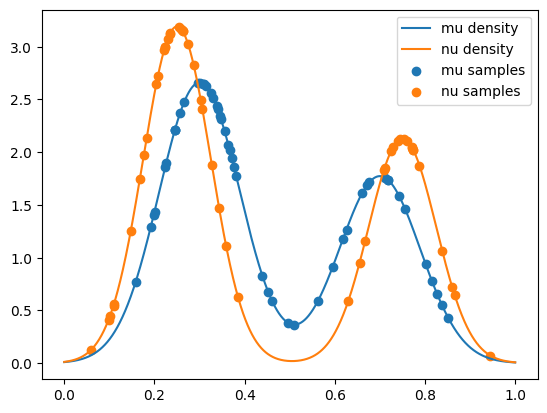

In [72]:
x = np.linspace(0, 1, n)

f, ax = plt.subplots()

ax.plot(x, mu, label = 'mu density')
ax.plot(x, nu, label = 'nu density')

ax.scatter(X, mu[(n * X).astype(int)], label = 'mu samples')
ax.scatter(Y, nu[np.minimum((n * Y).astype(int), n-1)], label = 'nu samples')


plt.legend()
plt.show()

In [73]:
### Sobol quasi-random samples to fill the space X x Y. 
sob = i4_sobol_generate(2 , nfill, skip = 3000)


## Add some points in the corners (optional)
sob = np.insert(sob, 0, np.array([1e-2, 1e-2]))
sob = np.insert(sob, 0, np.array([1-1e-2, 1-1e-2]))
sob = np.insert(sob, 0, np.array([1e-2, 1-1e-2]))
sob = np.insert(sob, 0, np.array([1.-1e-2, 1e-2]))

sob = sob.reshape(-1, 2)[:-4 , :]


X_fill = sob[:, :1]
Y_fill = sob[:, 1:] 

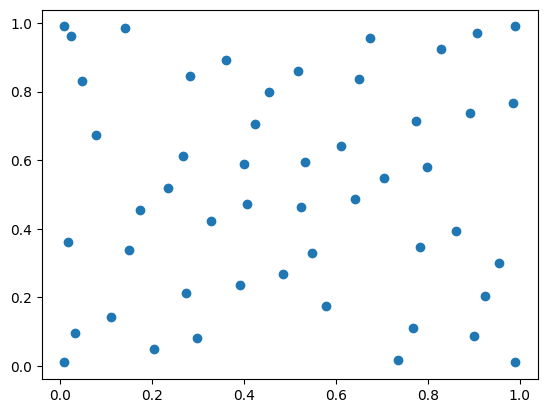

In [74]:
plt.scatter(X_fill, Y_fill)

In [75]:
kernel = 'gaussian'
l = .1
Phi, M, Kx1, Ky1, Kx2, Ky2, Kx3, Ky3 = make_kernels(X[:, None], Y[:, None], X_fill, Y_fill, l=l, kernel = kernel)

In [76]:
data = {}
data["Phi"] = Phi
data["KX1"] = Kx1
data["KX2"] = Kx2
data["KX3"] = Kx3
data["KY1"] = Ky1
data["KY2"] = Ky2
data["KY3"] = Ky3
data["M"] = M


In [77]:
## Regularization parameters

lbda_1 = 1 / nfill
lbda_2 =  1 / np.sqrt(nsamples)

In [78]:
gamma, c, t, res_time, res_norm = SSN(data, alph_1 = 1e-6, alph_2 =1, beta_0 = 0.5, beta_1 = 1.2 ,
                                       beta_2 = 5, theta_upper = 50,theta_lower = 1e-16, reg1 = lbda_1, 
                                       reg2 = lbda_2, EG_rate = 0.0003, nIter = 2000, verbose = True)


-------------- SSNEG ---------------
iter |  cost  |  residue  |  time
   50|3.24e-01|1.03e+01|3.00e-01
  100|2.45e-01|1.07e+01|5.39e-01
  150|2.07e-01|9.17e+00|8.14e-01
  200|1.84e-01|1.05e+01|1.12e+00
  250|1.69e-01|8.27e+00|1.35e+00
  300|1.59e-01|1.26e+01|1.63e+00
  350|1.52e-01|8.44e+00|1.88e+00
  400|1.47e-01|1.29e+01|2.11e+00
  450|1.44e-01|1.37e+01|2.30e+00
  500|2.33e-01|2.89e+00|2.53e+00
  550|3.15e-01|3.03e+00|2.77e+00
  600|3.15e-01|2.97e+00|2.97e+00
  650|2.26e-01|4.74e+00|3.21e+00
  700|2.26e-01|1.46e+00|3.43e+00
  750|2.26e-01|3.44e+00|3.64e+00
  800|2.26e-01|5.56e+00|3.87e+00
  850|2.26e-01|5.33e+00|4.09e+00
  900|1.40e-01|8.54e+00|4.31e+00
  950|1.41e-01|7.35e+00|4.54e+00
 1000|1.42e-01|1.02e+01|4.74e+00
 1050|1.44e-01|8.70e+00|4.94e+00
 1100|1.45e-01|7.40e+00|5.15e+00
 1150|1.47e-01|1.45e+01|5.43e+00
 1200|1.48e-01|1.47e+01|5.63e+00
 1250|1.50e-01|9.43e+00|5.82e+00
 1300|1.52e-01|1.57e+01|6.01e+00
 1350|1.54e-01|1.53e+01|6.21e+00
 1400|1.56e-01|1.58e+01|6.60e+00
 145

In [79]:
kernel_sos_ot = transport_cost(gamma, Kx2, Kx3, Ky2, Ky3, lbda_2, product_sampling=False)
kernel_sos_ot

0.1832091516242049

In [80]:
### Compute OT from samples
x = np.linspace(0., 1., n)

M_ot = ((x[:, None] - x)**2) / 2
P, log = ot.emd(mu / mu.sum(), nu / nu.sum(), M_ot, log = True)
sampled_ot = (P * M_ot).sum()

In [81]:
print(f"Plugin estimator (n={n}): {sampled_ot:.3e}\nKernel SoS estimator (n={nsamples}, l={nfill}): {kernel_sos_ot:.3e}")

Plugin estimator (n=2000): 1.308e-03
Kernel SoS estimator (n=50, l=50): 1.832e-01


<Figure size 640x480 with 0 Axes>

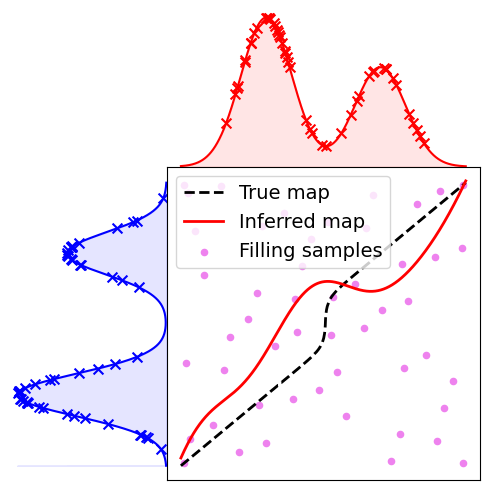

In [82]:
import matplotlib.gridspec as gridspec

plt.clf()

fig = plt.figure(figsize=(5, 5))

gs = gridspec.GridSpec(3, 3, wspace=0.0, hspace=0.0)

xp, yp = np.where(P > 0)

na, nb = P.shape

xa = np.arange(na)
xb = np.arange(nb)

Txa = np.argmax(P, 1)


ax1 = plt.subplot(gs[0, 1:])
ax1.plot(xa, mu,  'r', label='Source distribution')
ax1.fill_between(xa, mu, color = 'red', alpha=.1)
plt.ylim(ymin=0)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
ax1.axis('off')

ax2 = plt.subplot(gs[1:, 0])
ax2.plot((nu), xb, 'b', label='Target distribution')
ax2.fill_between((nu)[:], xb[:], color = 'blue', interpolate=True, alpha = .1)
ax2.set_xlim(xmin=0)
ax2.invert_xaxis()

ax2.axis('off')


ax3 = plt.subplot(gs[1:, 1:], sharex=ax1, sharey=ax2)
ax3.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

ax3.plot(xa, Txa , linewidth = 2, color = 'black', ls ='--', label='True map')

x = np.linspace(0, 1, len(xa)) 
TX = transport_1D(x, gamma, X, X_fill, lbda_2, kernel=kernel, l=l) 

ax3.plot(xa, TX * na, color = 'r', lw =2, label = 'Inferred map')

ax1.scatter(X * na, mu[(n * X).astype(int)], label = 'mu samples', marker = 'x', color = 'r', s=50)
ax2.scatter( nu[np.minimum((n * Y).astype(int), n-1)], Y * na, 
            label = 'nu samples', marker = 'x', color = 'b', s = 50)


ax3.scatter(sob[:, 0] * na, sob[:, 1] * na, color = 'violet', s =20, label = 'Filling samples')

    
plt.tight_layout()
plt.legend(fontsize = 14)

plt.show()